In [2]:
import pandas as pd
import numpy as np
import math
import json

In [3]:
import os
working_directory = os.getcwd()
print(working_directory)

/Users/roland


In [6]:
# read the json files
portfolio = pd.read_json(working_directory + '/desktop/portfolio.json', orient='records', lines=True) 
profile = pd.read_json(working_directory + '/desktop/profile.json', orient='records', lines=True)
transcript = pd.read_json(working_directory + '/desktop/transcript.json', orient='records', lines=True)


We have to find a way to combine the data as is to form a single dataset

First thing we can do is check if all the different files have matching profiles and check to ensure there aren't any extra customer records in transcript and profile jsons 

In [7]:
if(pd.unique(transcript['person']).shape == pd.unique(profile['id']).shape):
    print("Success")
else:
    print("Failure")

Success


In [8]:
customer_ids = pd.unique(transcript['person'])

#encode customer ids which is in string format to integers
customer_ids_dict = pd.Series(customer_ids).to_dict()
customer_ids_dict = dict([(value, key) for key, value in customer_ids_dict.items()]) 
itr = iter(customer_ids_dict.items())
lst = [next(itr) for i in range(10)]
print(lst)

[('78afa995795e4d85b5d9ceeca43f5fef', 0), ('a03223e636434f42ac4c3df47e8bac43', 1), ('e2127556f4f64592b11af22de27a7932', 2), ('8ec6ce2a7e7949b1bf142def7d0e0586', 3), ('68617ca6246f4fbc85e91a2a49552598', 4), ('389bc3fa690240e798340f5a15918d5c', 5), ('c4863c7985cf408faee930f111475da3', 6), ('2eeac8d8feae4a8cad5a6af0499a211d', 7), ('aa4862eba776480b8bb9c68455b8c2e1', 8), ('31dda685af34476cad5bc968bdb01c53', 9)]


In [9]:
#map encoded customer ids to ids in transcrpt and profile dataframes
transcript['person'] = transcript['person'].map(customer_ids_dict)
profile['id'] = profile['id'].map(customer_ids_dict)

In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,14980,20170212,NaN
1,F,55,12990,20170715,112000.0
2,None,118,14643,20180712,NaN
3,F,75,0,20170509,100000.0
4,None,118,1,20170804,NaN


In [11]:
transcript.head()

,person,event,value,time
0,0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [12]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [13]:
#sort transcript and profile dataframe rows based on customer ids
sorted_transcript = transcript.sort_values('person', axis=0, ascending=True, inplace=False, kind='quicksort')
sorted_profile = profile.sort_values('id', axis=0, ascending=True, inplace=False, kind='quicksort')

In [28]:
#reset index to the current form i.e. after sort
sorted_transcript.reset_index(inplace=True)

In [29]:
#drop the column index
sorted_transcript = sorted_transcript.drop(labels=['index'], axis=1)

In [30]:
sorted_transcript.head()

,person,event,value,time
0,0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,0,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582
2,0,transaction,{'amount': 19.67},222
3,0,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
4,0,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216


In [17]:
#reset index to the current form i.e. after sort
sorted_profile.reset_index(inplace=True)

In [18]:
#drop the column index as it is not required
sorted_profile = sorted_profile.drop(labels=['index'], axis=1)

In [19]:
sorted_profile.head()

,gender,age,id,became_member_on,income
0,F,75,0,20170509,100000.0
1,None,118,1,20170804,NaN
2,M,68,2,20180426,70000.0
3,None,118,3,20170925,NaN
4,None,118,4,20171002,NaN


In [31]:
#find frequency of each customer ids in the transcript dataframe
customer_ids_frequency = sorted_transcript['person'].value_counts(sort=False)

In [32]:
#to perform repeatation of records, the repeat count is to be added along each corresponding rows
sorted_profile = pd.concat([sorted_profile, customer_ids_frequency], axis=1)

In [33]:
sorted_profile.head()

,gender,age,id,became_member_on,income,person
0,F,75,0,20170509,100000.0,18
1,None,118,1,20170804,NaN,11
2,M,68,2,20180426,70000.0,12
3,None,118,3,20170925,NaN,10
4,None,118,4,20171002,NaN,11


In [34]:
#duplicate each rows in sorted profile based on the frequency of each customer ids in transcript
profile_with_duplicate_rows = sorted_profile.reindex(sorted_profile.index.repeat(sorted_profile.person))

In [35]:
#reset index to the current form i.e. after sort
profile_with_duplicate_rows.reset_index(inplace=True)

In [36]:
#drop the columns index and person as they aren't anymore required
profile_with_duplicate_rows = profile_with_duplicate_rows.drop(labels=['index', 'person'], axis=1)

In [37]:
profile_with_duplicate_rows.head()

,gender,age,id,became_member_on,income
0,F,75,0,20170509,100000.0
1,F,75,0,20170509,100000.0
2,F,75,0,20170509,100000.0
3,F,75,0,20170509,100000.0
4,F,75,0,20170509,100000.0


In [38]:
#concatenate sorted transcript and profile with duplicate rows
transcript_profile_concatenated = pd.concat([sorted_transcript, profile_with_duplicate_rows], axis=1)

In [39]:
transcript_profile_concatenated.tail()

,person,event,value,time,gender,age,id,became_member_on,income
306529,16997,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},594,None,118,16997,20170926,NaN
306530,16997,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,None,118,16997,20170926,NaN
306531,16998,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0
306532,16998,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0
306533,16999,transaction,{'amount': 0.35000000000000003},582,None,118,16999,20170801,NaN


In [40]:
#verify whether customer ids from transcript and profile are aligned correctly
(transcript_profile_concatenated['person'] == transcript_profile_concatenated['id']).all()

True

In [41]:
#drop the column person as it is not anymore required
transcript_profile_concatenated = transcript_profile_concatenated.drop(labels=['person'], axis=1)

In [42]:
transcript_profile_concatenated

,event,value,time,gender,age,id,became_member_on,income
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,0,20170509,100000.0
1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582,F,75,0,20170509,100000.0
2,transaction,{'amount': 19.67},222,F,75,0,20170509,100000.0
3,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,0,20170509,100000.0
4,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,0,20170509,100000.0
...,...,...,...,...,...,...,...,...
306529,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},594,None,118,16997,20170926,NaN
306530,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,None,118,16997,20170926,NaN
306531,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0
306532,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0


In [43]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [44]:
#encode offer ids in portfolio dataframe from string format to integer
offer_ids = portfolio['id'].unique()
offer_ids_dict = pd.Series(offer_ids).to_dict()
offer_ids_dict = dict([(value, key) for key, value in offer_ids_dict.items()]) 

In [45]:
offer_ids_dict

{'ae264e3637204a6fb9bb56bc8210ddfd': 0,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 1,
 '3f207df678b143eea3cee63160fa8bed': 2,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 3,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 4,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 5,
 'fafdcd668e3743c1bb461111dcafc2a4': 6,
 '5a8bc65990b245e5a138643cd4eb9837': 7,
 'f19421c1d4aa40978ebb69ca19b0e20d': 8,
 '2906b810c7d4411798c6938adc9daaa5': 9}

In [46]:
#map ids in portfolio to encoded offer ids
portfolio['id'] = portfolio['id'].map(offer_ids_dict)

In [47]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,0
1,10,"[web, email, mobile, social]",10,5,bogo,1
2,0,"[web, email, mobile]",0,4,informational,2
3,5,"[web, email, mobile]",5,7,bogo,3
4,5,"[web, email]",20,10,discount,4
5,3,"[web, email, mobile, social]",7,7,discount,5
6,2,"[web, email, mobile, social]",10,10,discount,6
7,0,"[email, mobile, social]",0,3,informational,7
8,5,"[web, email, mobile, social]",5,5,bogo,8
9,2,"[web, email, mobile]",10,7,discount,9


In [48]:
#inspect random rows for any error
fraction_of_rows = transcript_profile_concatenated.sample(frac=0.003)
fraction_of_rows

,event,value,time,gender,age,id,became_member_on,income
242489,transaction,{'amount': 3.85},12,M,43,12895,20150201,44000.0
137166,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},504,M,41,7281,20151121,64000.0
205278,transaction,{'amount': 19.84},132,M,41,10910,20170714,63000.0
223358,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},18,F,54,11870,20170519,48000.0
161177,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},168,F,71,8550,20160905,113000.0
...,...,...,...,...,...,...,...,...
51059,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,M,43,2708,20180724,56000.0
39275,transaction,{'amount': 23.3},462,M,68,2081,20151110,74000.0
305341,transaction,{'amount': 0.16},486,M,73,16871,20180312,64000.0
45123,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,F,70,2387,20170625,77000.0


In [49]:
transcript_profile_concatenated.tail()

,event,value,time,gender,age,id,became_member_on,income
306529,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},594,None,118,16997,20170926,NaN
306530,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,None,118,16997,20170926,NaN
306531,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0
306532,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0
306533,transaction,{'amount': 0.35000000000000003},582,None,118,16999,20170801,NaN


In [50]:
transcript_profile_concatenated.head()

,event,value,time,gender,age,id,became_member_on,income
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,0,20170509,100000.0
1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582,F,75,0,20170509,100000.0
2,transaction,{'amount': 19.67},222,F,75,0,20170509,100000.0
3,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,0,20170509,100000.0
4,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,0,20170509,100000.0


In [51]:
#get a series of offer ids from the concatenated dataframe
offer_id_series = transcript_profile_concatenated['value']

In [52]:
def get_dict_values(x):
    """Finds the first value of the key from a single key-value pair.
    
    Args:
        x (dictionary object): Expects a dictionary key-value pair.
    
    Returns:
        value: First value from the passed key-value pair.
        
    """
    key = list(x.keys())[0]
    value = x[key]
    return value

In [53]:
#map every element of offer id series to the function get_dict_values(). This step is essential as every 
#element in offer id series exists as a dictionary key-value pair.
offer_id_series = pd.DataFrame(offer_id_series).applymap(lambda x: get_dict_values(x))

In [54]:
offer_id_series.head()

,value
0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,f19421c1d4aa40978ebb69ca19b0e20d
2,19.67
3,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5a8bc65990b245e5a138643cd4eb9837


In [55]:
def encode_offer_id(x):
    """Encode the given string into a integer based on the dictionary offer_ids_dict.
    
    Args:
        x (str or int): Expects an integer or string value from offer_id_series.
    
    Return:
        10 or offer_id_dict[x]: 10 is returned if the passed argument is integer and if the argument is a string,
                                the value for the key, x in offer_id_dict is returned.
    """
    if(type(x) is str):
        return offer_ids_dict[x]
    else:
        return 10

In [56]:
#map offer id series to the function encode_offer_id()
encoded_offer_id_series = offer_id_series.applymap(lambda x: encode_offer_id(x))

In [57]:
encoded_offer_id_series.head()

,value
0,3
1,8
2,10
3,3
4,7


In [58]:
#add the column, offer_id with values from encoded_offer_id_series dataframe to the dataframe 
#transcript_profile_portfolio_concatenated
transcript_profile_portfolio_concatenated = transcript_profile_concatenated
transcript_profile_portfolio_concatenated['offer_id'] = encoded_offer_id_series['value']

In [59]:
transcript_profile_portfolio_concatenated.head(10)

,event,value,time,gender,age,id,became_member_on,income,offer_id
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,0,20170509,100000.0,3
1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582,F,75,0,20170509,100000.0,8
2,transaction,{'amount': 19.67},222,F,75,0,20170509,100000.0,10
3,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,0,20170509,100000.0,3
4,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,0,20170509,100000.0,7
5,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,F,75,0,20170509,100000.0,7
6,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},504,F,75,0,20170509,100000.0,8
7,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,510,F,75,0,20170509,100000.0,8
8,transaction,{'amount': 23.93},378,F,75,0,20170509,100000.0,10
9,transaction,{'amount': 19.89},132,F,75,0,20170509,100000.0,10


In [60]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,0
1,10,"[web, email, mobile, social]",10,5,bogo,1
2,0,"[web, email, mobile]",0,4,informational,2
3,5,"[web, email, mobile]",5,7,bogo,3
4,5,"[web, email]",20,10,discount,4
5,3,"[web, email, mobile, social]",7,7,discount,5
6,2,"[web, email, mobile, social]",10,10,discount,6
7,0,"[email, mobile, social]",0,3,informational,7
8,5,"[web, email, mobile, social]",5,5,bogo,8
9,2,"[web, email, mobile]",10,7,discount,9


In [61]:
#convert the columns reward, difficulty and duration of portfolio dataframe into dictionaries 
portfolio_reward_dict = portfolio['reward'].to_dict()
portfolio_difficulty_dict = portfolio['difficulty'].to_dict()
portfolio_duration_dict = portfolio['duration'].to_dict()

In [62]:
def add_column(column_name, column_dict):
    """To add new column to the transcript_profile_portfolio_concatenated dataframe.
    
    Args:
        column_name (str): Name of the column to be added.
        column_dict (dict): Dictionary with column name as the key and values as data to the column.
        
    Return:
        None
    """
    transcript_profile_portfolio_concatenated[column_name] = transcript_profile_portfolio_concatenated['offer_id'].map(column_dict)

In [63]:
add_column('reward', portfolio_reward_dict)
add_column('difficulty', portfolio_difficulty_dict)
add_column('duration', portfolio_duration_dict)

In [64]:
transcript_profile_portfolio_concatenated.head()

,event,value,time,gender,age,id,became_member_on,income,offer_id,reward,difficulty,duration
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,0,20170509,100000.0,3,5.0,5.0,7.0
1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582,F,75,0,20170509,100000.0,8,5.0,5.0,5.0
2,transaction,{'amount': 19.67},222,F,75,0,20170509,100000.0,10,NaN,NaN,NaN
3,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,0,20170509,100000.0,3,5.0,5.0,7.0
4,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,0,20170509,100000.0,7,0.0,0.0,3.0


In [65]:
#inspect random rows to find the basic structure of the column became_member_on
transcript_profile_portfolio_concatenated['became_member_on'].sample(frac=.003)

34494     20180102
159278    20180528
182607    20160804
206978    20131120
272077    20160722
            ...   
173499    20141004
45934     20171215
303316    20170731
301703    20171025
13040     20161114
Name: became_member_on, Length: 920, dtype: int64

In [66]:
def find_month(x):
    """To find month from the passed numerical date of the format YYYYMMDD.
    
    Args:
        x (int): Date which is of the form YYYYMMDD.
        
    Return:
        x%100 (int): MM of the date is returned.
    """
    x = x/100
    x = int(x)
    return x%100

In [67]:
#map the column reg_month to the find_month() function
transcript_profile_portfolio_concatenated['reg_month'] = transcript_profile_portfolio_concatenated['became_member_on'].map(lambda x: find_month(x))

In [68]:
transcript_profile_portfolio_concatenated.head()

,event,value,time,gender,age,id,became_member_on,income,offer_id,reward,difficulty,duration,reg_month
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,0,20170509,100000.0,3,5.0,5.0,7.0,5
1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582,F,75,0,20170509,100000.0,8,5.0,5.0,5.0,5
2,transaction,{'amount': 19.67},222,F,75,0,20170509,100000.0,10,NaN,NaN,NaN,5
3,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,0,20170509,100000.0,3,5.0,5.0,7.0,5
4,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,0,20170509,100000.0,7,0.0,0.0,3.0,5


In [69]:
#encode event ids in string format to integer
event_ids = transcript_profile_portfolio_concatenated['event'].unique()
event_ids_dict = pd.Series(event_ids).to_dict()
event_ids_dict = dict([(value, key) for key, value in event_ids_dict.items()]) 

In [70]:
#add one more event to the dictionary, green flag which indicates the customer does not view the 
#offer but completes the offer. Thus, it's a green flag in a business perspective.
event_ids_dict['green flag'] = 4
event_ids_dict

{'offer received': 0,
 'offer viewed': 1,
 'transaction': 2,
 'offer completed': 3,
 'green flag': 4}

In [71]:
#map event_ids to the encoded event ids
transcript_profile_portfolio_concatenated['event_id'] = transcript_profile_portfolio_concatenated['event'].map(event_ids_dict)

In [72]:
transcript_profile_portfolio_concatenated

,event,value,time,gender,age,id,became_member_on,income,offer_id,reward,difficulty,duration,reg_month,event_id
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,0,20170509,100000.0,3,5.0,5.0,7.0,5,0
1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582,F,75,0,20170509,100000.0,8,5.0,5.0,5.0,5,1
2,transaction,{'amount': 19.67},222,F,75,0,20170509,100000.0,10,NaN,NaN,NaN,5,2
3,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,0,20170509,100000.0,3,5.0,5.0,7.0,5,1
4,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,0,20170509,100000.0,7,0.0,0.0,3.0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},594,None,118,16997,20170926,NaN,1,10.0,10.0,5.0,9,1
306530,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,None,118,16997,20170926,NaN,1,10.0,10.0,5.0,9,0
306531,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0,1,10.0,10.0,5.0,10,0
306532,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,16998,20161020,78000.0,1,10.0,10.0,5.0,10,1


In [73]:
#sort the transcript_profile_portfolio_concatenated dataframe based on id, offer_id and event_id for easy feature engineering later
sorted_dataset = transcript_profile_portfolio_concatenated.sort_values(by=['id', 'offer_id', 'event_id'], ascending=[True, True, False])

In [74]:
sorted_dataset.head(20)

,event,value,time,gender,age,id,became_member_on,income,offer_id,reward,difficulty,duration,reg_month,event_id
11,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,510,F,75,0,20170509,100000.0,0,10.0,10.0,7.0,5,3
12,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},408,F,75,0,20170509,100000.0,0,10.0,10.0,7.0,5,1
13,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},408,F,75,0,20170509,100000.0,0,10.0,10.0,7.0,5,0
17,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,F,75,0,20170509,100000.0,3,5.0,5.0,7.0,5,3
3,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,0,20170509,100000.0,3,5.0,5.0,7.0,5,1
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,0,20170509,100000.0,3,5.0,5.0,7.0,5,0
4,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,F,75,0,20170509,100000.0,7,0.0,0.0,3.0,5,1
5,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,F,75,0,20170509,100000.0,7,0.0,0.0,3.0,5,0
7,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,510,F,75,0,20170509,100000.0,8,5.0,5.0,5.0,5,3
1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582,F,75,0,20170509,100000.0,8,5.0,5.0,5.0,5,1


In [75]:
#reset index to the current form i.e. after sort
sorted_dataset.reset_index(inplace=True)

In [76]:
#form the dataset with only columns that are required for later cases
columns=['id', 'offer_id', 'event_id', 'gender', 'age', 'income', 'reward', 'difficulty', 'reg_month']
dataset = sorted_dataset[columns]

In [77]:
dataset.shape

(306534, 9)

In [78]:
#dataframe for storing dataframe from dataset after filtering out unwanted rows
dataset_after_filter = pd.DataFrame()

In [79]:
def aggregate(x):
    """To find sum of the current element and all the previous elements and storing it in the current position.
       This is to be done from start of the list to the end.
       
    Args:
        x (list): List of integer values.
        
    Returns:
        x (list): Function will be performed to every element from start to end. Last element will be removed 
        from the list before returning.
    
    """
    for i in range(1, len(x)):
        x[i] = x[i] + x[i-1]
    x.pop()
    return x

In [80]:
import warnings
warnings.simplefilter('ignore')

In [81]:
%%time

#find and select only the records from the dataset for which the event performed by the customer for each offers
#send to them is the highest. And, change the event id of those selected records with event id = 1 into 
#event id = 2 if there is a transaction event happened for the same customer; otherwise, it's not changed. 
#Similarly, if in the selected records, if there is event id = 3 and the event id of the next data record in the 
#dataset is zero then the erecord with event id = 3 is changed to event id = 4

#loop through each customer ids
for i in range(len(dataset['id'].unique())):    
    #select the data records of i th customer from dataset 
    dataset_temp = dataset[dataset['id'] == i]
    customer_id_index = dataset_temp['id'].index
    #start index of dataframe of i th customer
    start_index = customer_id_index[0] 
    
    #find the frequency of each offer ids such that sorting of these values is set to false
    offer_count = dataset_temp['offer_id'].value_counts(sort=False)
    #find the index of offer ids with just a single record
    single_offer_index = offer_count[offer_count == 1].index
    #add 0 to the 0th index of the offer_count_list 
    offer_count_list = offer_count.to_list()
    offer_count_list.insert(0, 0)
    offer_index = pd.Series(aggregate(offer_count_list))
    #start index for each customer while each iteration is added
    offer_index = offer_index.apply(lambda x: x + start_index)
    
    #check whether 1 exist at any indexes specified by the series offer_index and if there is any, store 
    #those indexes to the variable event_one_exist.
    event_one_exist = dataset.iloc[offer_index, dataset.columns.get_loc('event_id')] == 1
    event_one_exist = event_one_exist[event_one_exist==1].index
    
    #check whether 10 exist in the i th dataframe and if there is any, store those indexes to the 
    #variable offer_ten_exist
    offer_ten_exist = dataset_temp[dataset_temp['offer_id']==10].index
    
    #when index of offer_count_list increased by one by adding zero, offer count hadn't increased the index.
    if(len(single_offer_index)!=0):
        single_offer_index = list(single_offer_index.map(lambda x: x+1))
    
    #check whether 3 exist at any indexes specified by the series offer_index and if there is any, store 
    #those indexes to the variable event_three_exist
    event_three_exist = dataset.iloc[offer_index, dataset.columns.get_loc('event_id')] == 3
    event_three_exist = event_three_exist[event_three_exist==1].index
    
    #find if the records specified in event_three_exist is a single offer record or not; if yes, pass the 
    #common value to the common_index variable
    common_index = set(event_three_exist).intersection(single_offer_index)
    common_index = list(common_index)
    
    #if there is any elements in common_index, remove those from the event_three_exist variable
    if(len(common_index)!=0):
        indices_B = [event_three_exist.index(x) for x in common_index]
        event_three_exist = [i for j, i in enumerate(event_three_exist) if j not in indices_B]
        
    #pointer to the record next to the records with event_id = 3
    event_three_next = pd.Series(event_three_exist).apply(lambda x: x+1)
    
    #check whether 0 exist at any indexes specified by the series event_three_next and if there is any, store 
    #those indexes to the variable event_zero_exist
    event_zero_exist = dataset.iloc[event_three_next, dataset.columns.get_loc('event_id')] == 0
    event_zero_exist = event_zero_exist[event_zero_exist==1].index

    #If any event_id = 1 and offer ten exist, then the event_ids are made to 2 for all index values in 
    #event_one_exist
    if(len(event_one_exist)!=0 and len(offer_ten_exist)!=0):
        dataset.iloc[event_one_exist, dataset.columns.get_loc('event_id')] = 2
    
    #If any event_id = 3 and the next record's event_id = 0, then the event_ids are made to 4 for all 
    #index values in event_zero_exist(values of event_zero_exist are reduced by one)
    if(len(event_three_exist)!=0 and len(event_zero_exist)!=0):
        event_zero_exist = pd.Series(event_zero_exist).apply(lambda x: x-1)
        dataset.iloc[list(event_zero_exist), dataset.columns.get_loc('event_id')] = 4    
    
    #For each iteration or customer ids, records of the dataset at the indexes specified by offer_index is appended
    #to the dataframe dataset_after_filter
    dataset_after_filter = dataset_after_filter.append(dataset[dataset.index.isin(offer_index)], ignore_index=True)

CPU times: user 5min 10s, sys: 14.9 s, total: 5min 25s
Wall time: 5min 18s


In [82]:
dataset_after_filter.shape

(79866, 9)

In [83]:
dataset_after_filter.head(100)

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
0,0,0,3,F,75,100000.0,10.0,10.0,5
1,0,3,3,F,75,100000.0,5.0,5.0,5
2,0,7,2,F,75,100000.0,0.0,0.0,5
3,0,8,3,F,75,100000.0,5.0,5.0,5
4,0,10,2,F,75,100000.0,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...
95,20,3,4,F,96,89000.0,5.0,5.0,11
96,20,5,4,F,96,89000.0,3.0,7.0,11
97,20,7,2,F,96,89000.0,0.0,0.0,11
98,20,8,3,F,96,89000.0,5.0,5.0,11


In [84]:
#as offer_id = 10 doesn't actually represent any offer by itself, all the rows containing offer_id = 10 is dropped
dataset_after_filter = dataset_after_filter.drop(dataset_after_filter[dataset_after_filter['offer_id']==10].index, axis=0)

In [85]:
dataset_after_filter.head()

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
0,0,0,3,F,75,100000.0,10.0,10.0,5
1,0,3,3,F,75,100000.0,5.0,5.0,5
2,0,7,2,F,75,100000.0,0.0,0.0,5
3,0,8,3,F,75,100000.0,5.0,5.0,5
5,1,2,2,None,118,NaN,0.0,0.0,8


In [86]:
dataset_after_filter.shape

(63334, 9)

In [87]:
#reset index to the current form i.e. after sort
dataset_after_filter.reset_index(inplace=True)

In [88]:
#drop the column index as it is not required
dataset_after_filter = dataset_after_filter.drop(labels=['index'], axis=1)

In [89]:
dataset_after_filter.isna().sum()

id               0
offer_id         0
event_id         0
gender        8077
age              0
income        8077
reward           0
difficulty       0
reg_month        0
dtype: int64

In [90]:
#encode the column 'gender' in the string format to integer
gender_dict = {'O': 0, 'M': 1, 'F': 2}
dataset_after_filter['gender'] = dataset_after_filter['gender'].map(gender_dict)

In [91]:
dataset_after_filter

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
0,0,0,3,2.0,75,100000.0,10.0,10.0,5
1,0,3,3,2.0,75,100000.0,5.0,5.0,5
2,0,7,2,2.0,75,100000.0,0.0,0.0,5
3,0,8,3,2.0,75,100000.0,5.0,5.0,5
4,1,2,2,NaN,118,NaN,0.0,0.0,8
...,...,...,...,...,...,...,...,...,...
63329,16995,2,1,1.0,47,94000.0,0.0,0.0,10
63330,16996,6,3,NaN,118,NaN,2.0,10.0,12
63331,16996,6,0,NaN,118,NaN,2.0,10.0,12
63332,16997,1,1,NaN,118,NaN,10.0,10.0,9


In [92]:
dataset_after_filter.isna().sum()

id               0
offer_id         0
event_id         0
gender        8077
age              0
income        8077
reward           0
difficulty       0
reg_month        0
dtype: int64

In [93]:
dataset_after_filter.describe()

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
count,63334.000000,63334.000000,63334.000000,55257.000000,63334.000000,55257.000000,63334.000000,63334.000000,63334.000000
mean,8203.259671,4.485300,2.192377,1.399316,62.466985,65406.663409,4.209271,7.707345,6.675546
std,4807.868989,2.868289,1.124005,0.517398,26.736170,21628.999297,3.404476,5.536333,3.490682
min,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,1.000000
25%,4059.000000,2.000000,2.000000,1.000000,45.000000,49000.000000,2.000000,5.000000,4.000000
50%,8129.000000,4.000000,2.000000,1.000000,58.000000,64000.000000,5.000000,10.000000,7.000000
75%,12185.000000,7.000000,3.000000,2.000000,73.000000,80000.000000,5.000000,10.000000,10.000000
max,16998.000000,9.000000,4.000000,2.000000,118.000000,120000.000000,10.000000,20.000000,12.000000


In [94]:
dataset_after_filter.to_csv('data.csv', index=False)

In [98]:
data = pd.read_csv(working_directory + '/desktop/data.csv')

In [101]:
data.head()

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
0,0,0,3,2.0,75,100000.0,10,10,5
1,0,3,3,2.0,75,100000.0,5,5,5
2,0,7,2,2.0,75,100000.0,0,0,5
3,0,8,3,2.0,75,100000.0,5,5,5
4,1,2,2,NaN,118,NaN,0,0,8


Exploratory Data Analysis (EDA)

1. Variable Identification

Identify the types and categories of all the data variables.

First, let's inspect the data variables that exists in the three files that is available to us from Starbucks.

In [102]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,0
1,10,"[web, email, mobile, social]",10,5,bogo,1
2,0,"[web, email, mobile]",0,4,informational,2
3,5,"[web, email, mobile]",5,7,bogo,3
4,5,"[web, email]",20,10,discount,4


We have reward (int), difficulty (int) and duration (int) as continuous values; where as channels (list of strings), offer_type (str) and id (str) as categorical data.

In [103]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,14980,20170212,NaN
1,F,55,12990,20170715,112000.0
2,None,118,14643,20180712,NaN
3,F,75,0,20170509,100000.0
4,None,118,1,20170804,NaN


We have age (int), became_member_on (int) and income (float) as continuous values; where as gender (str) and id (str) as categorical data.

In [104]:
transcript.head()

,person,event,value,time
0,0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,2,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,3,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,4,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


We have time (int) as continuous value; where as person (str), event (str) and value (dict of strings) as categorical data.

The identified input and output features/variables for our model are:

Predictor variables:

Difficulty

Reward

Gender

Age

Became_member_on (Only the month is considered and the feature name is changed to reg_month)

Income

Value (Feature name is changed to offer_id)

Target:

Event (Feature name is changed to event_id)

Let's import our combined dataset.

In [105]:
data = pd.read_csv('data.csv')

In [106]:
data.head()

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
0,0,0,3,2.0,75,100000.0,10.0,10.0,5
1,0,3,3,2.0,75,100000.0,5.0,5.0,5
2,0,7,2,2.0,75,100000.0,0.0,0.0,5
3,0,8,3,2.0,75,100000.0,5.0,5.0,5
4,1,2,2,NaN,118,NaN,0.0,0.0,8


Here, we have all the output and input features combined together and an additional variable 'id' which is nothing but the customer id.

2. Missing Value Treatment

Missing data in the training dataset can reduce the power / fit of a model or can lead to a biased model because we have not analysed the behavior and relationship with other variables correctly. It can lead to wrong prediction or classification.

Let's analyse the missing values in our dataset.

In [107]:
#Find the sum of all null or missing values in each variable of the dataset
data.isna().sum()

id               0
offer_id         0
event_id         0
gender        8077
age              0
income        8077
reward           0
difficulty       0
reg_month        0
dtype: int64

There are 8,077 missing values in each of the data variables 'gender' and 'income' (Both are part of the same record) of our dataset. Let's analyze these records alone to identify the reasons for occurrence of these missing values and the ways to treat it.

In [108]:
data[data['gender'].isna()]

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
4,1,2,2,NaN,118,NaN,0.0,0.0,8
5,1,4,2,NaN,118,NaN,5.0,20.0,8
6,1,7,0,NaN,118,NaN,0.0,0.0,8
11,3,1,1,NaN,118,NaN,10.0,10.0,9
12,3,2,1,NaN,118,NaN,0.0,0.0,9
...,...,...,...,...,...,...,...,...,...
63317,16988,3,3,NaN,118,NaN,5.0,5.0,12
63318,16988,3,2,NaN,118,NaN,5.0,5.0,12
63330,16996,6,3,NaN,118,NaN,2.0,10.0,12
63331,16996,6,0,NaN,118,NaN,2.0,10.0,12


From the above dataframe we can understand that even the age from these records are quite unreal. It's most probable that those missing records are because customers were not ready to submit the details and hence, the gender and income became missing values and age got its set default value i.e. 118.

Replacing missing values with mean/mode/median wouldn't be a good choice; as there are a large amount of records with missing values, mean/mode/median imputation could convey false information to the model. Since there are three features to be identified KNN imputation would also be risky and inefficient. Thus, the better option would be to delete those records. (Even after deleting those records with missing value, we will have 55,255 records for modeling)

In [109]:
data = data.dropna()

In [110]:
#reset the index 
data.reset_index(inplace=True)

In [111]:
#drop the column index as it is not required
data = data.drop(labels=['index'], axis=1)

In [112]:
data.isna().sum()

id            0
offer_id      0
event_id      0
gender        0
age           0
income        0
reward        0
difficulty    0
reg_month     0
dtype: int64

In [113]:
data.head()

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
0,0,0,3,2.0,75,100000.0,10.0,10.0,5
1,0,3,3,2.0,75,100000.0,5.0,5.0,5
2,0,7,2,2.0,75,100000.0,0.0,0.0,5
3,0,8,3,2.0,75,100000.0,5.0,5.0,5
4,2,2,0,1.0,68,70000.0,0.0,0.0,4


3. Univariate Analysis

At this stage, we explore variables one by one. Method to perform uni-variate analysis will depend on whether the variable type is categorical or continuous.

Continuous Variables:- We need to understand the central tendency and spread of the variable.

Categorical Variable:- We’ll use frequency table to understand distribution of each category.

3.1. Central Tendency

The mean is most likely the measure of central tendency, but there are others, such as the median and the mode. One of the main disadvantages of mean is that it is particularly susceptible to the influence of outliers. Since our dataset has no outliers we may use the mean and also, the histogram to visualize the same.

In [114]:
from matplotlib import pyplot as plt
%matplotlib inline

In [115]:
#Converting each column into numpy
income_np = data['income'].to_numpy()
offer_id_np = data['offer_id'].to_numpy()
event_id_np = data['event_id'].to_numpy()
age_np = data['age'].to_numpy()
gender_np = data['gender'].to_numpy()
reward_np = data['reward'].to_numpy()
difficulty_np = data['difficulty'].to_numpy()
reg_month_np = data['reg_month'].to_numpy()

In [116]:
data.describe()

,id,offer_id,event_id,gender,age,income,reward,difficulty,reg_month
count,55257.000000,55257.000000,55257.000000,55257.000000,55257.000000,55257.000000,55257.000000,55257.000000,55257.000000
mean,8203.927665,4.485767,2.255370,1.399316,54.349639,65406.663409,4.207014,7.715240,6.683732
std,4802.877112,2.867296,1.138163,0.517398,17.396266,21628.999297,3.403675,5.544446,3.493828
min,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,1.000000
25%,4062.000000,2.000000,2.000000,1.000000,42.000000,49000.000000,2.000000,5.000000,4.000000
50%,8123.000000,4.000000,3.000000,1.000000,55.000000,64000.000000,5.000000,10.000000,7.000000
75%,12184.000000,7.000000,3.000000,2.000000,66.000000,80000.000000,5.000000,10.000000,10.000000
max,16998.000000,9.000000,4.000000,2.000000,101.000000,120000.000000,10.000000,20.000000,12.000000


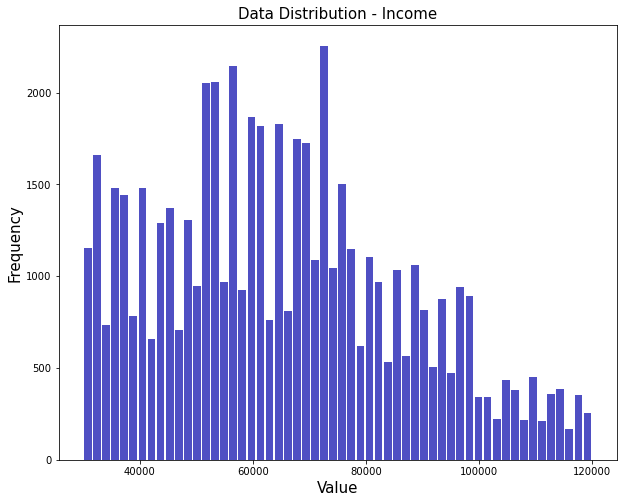

In [118]:
plt.figure(figsize=[10, 8])
n, bins, patches = plt.hist(x=income_np, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Data Distribution - Income',fontsize=15)
plt.show()

This histogram gives us the idea that our dataset lacks records or datapoints of customers who has income between 70,000 and 120,000. It's essentially a distribution which is positively skewed or right skewed. So in skewed data, the tail region may act as an outlier for the statistical model and we know that outliers adversely affect the model’s performance. Hence, we may need to normalize the data afterwards.

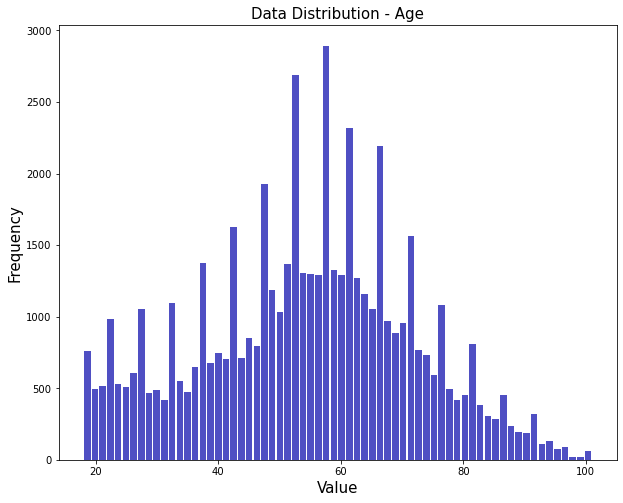

In [120]:
plt.figure(figsize=[10, 8])
n, bins, patches = plt.hist(x=age_np, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Data Distribution - Age',fontsize=15)
plt.show()

The distribution of the variable ‘age’ in the dataset is positively skewed or right skewed. Hence, we may need to standardize the same.

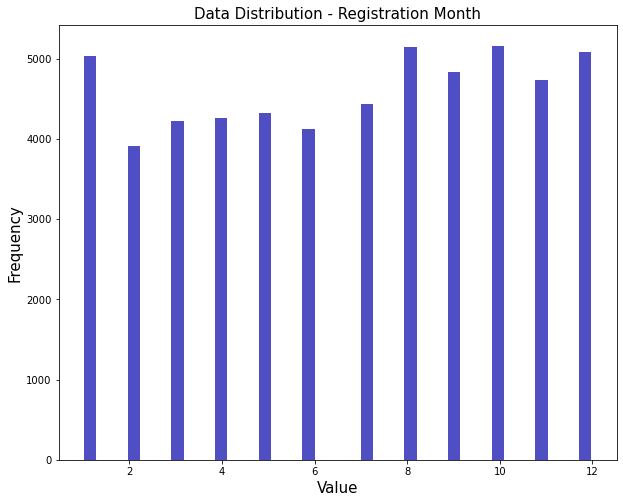

In [121]:
plt.figure(figsize=[10, 8])
n, bins, patches = plt.hist(x=reg_month_np, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Data Distribution - Registration Month',fontsize=15)
plt.show()

As the data distribution cannot be assumed as a gaussian distribution, we may not standardise the variable but we may normalize it to a normal scale such that there won’t be varying scales in the dataset and the algorithm we are using does not make assumptions about the distribution of the data.

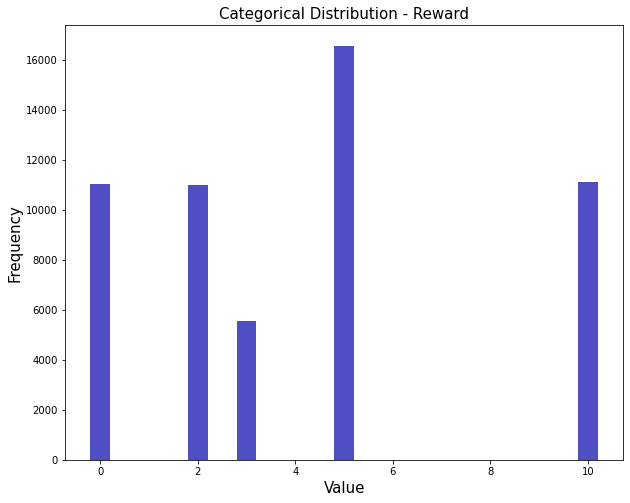

In [122]:
unique_elements, counts_elements = np.unique(reward_np, return_counts=True)

plt.figure(figsize=[10, 8])
p = plt.bar(unique_elements, counts_elements, color='#0504aa',alpha=0.7, width=.4)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Categorical Distribution - Reward',fontsize=15)
plt.show()

Normalization is to be done.

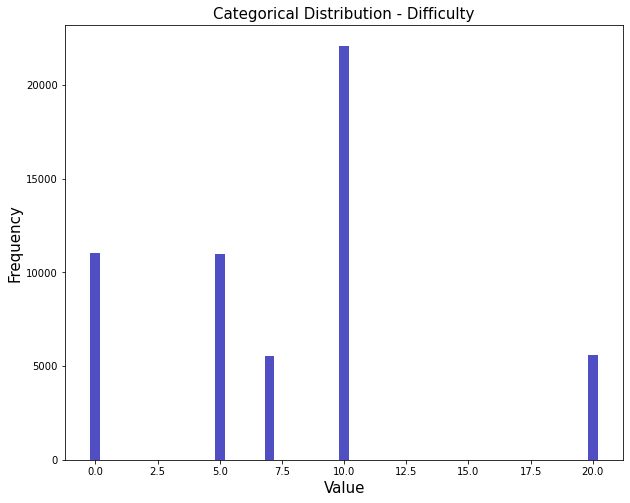

In [123]:
unique_elements, counts_elements = np.unique(difficulty_np, return_counts=True)

plt.figure(figsize=[10, 8])
p = plt.bar(unique_elements, counts_elements, color='#0504aa',alpha=0.7, width=.4)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Categorical Distribution - Difficulty',fontsize=15)
plt.show()

Normalization is to be done.

2.2. Frequency Table

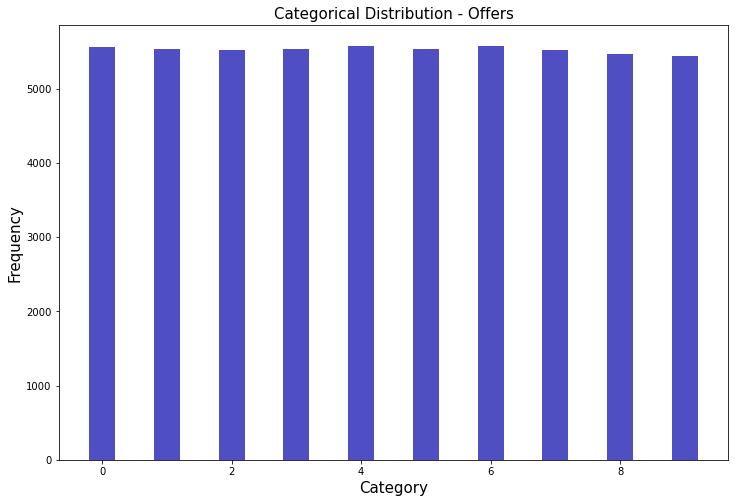

In [125]:
unique_elements, counts_elements = np.unique(offer_id_np, return_counts=True)

plt.figure(figsize=[12, 8])
p = plt.bar(unique_elements, counts_elements, color='#0504aa',alpha=0.7, width=.4)
plt.xlabel('Category',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Categorical Distribution - Offers',fontsize=15)
plt.show()

We have a balanced categorical data distribution for the variable ‘offers’ which can be encoded later using any suitable encoding scheme.

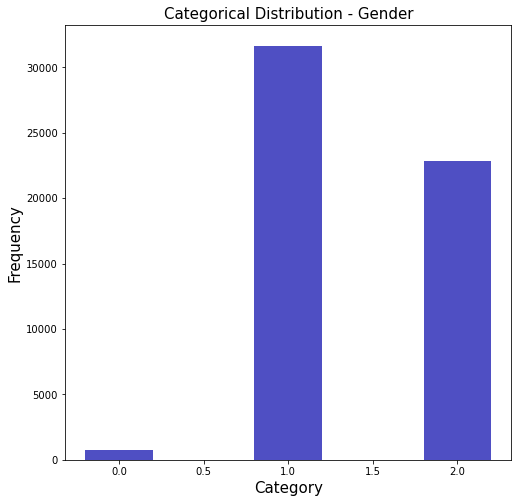

In [127]:
unique_elements, counts_elements = np.unique(gender_np, return_counts=True)

plt.figure(figsize=[8, 8])
p = plt.bar(unique_elements, counts_elements, color='#0504aa',alpha=0.7, width=.4)
plt.xlabel('Category',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Categorical Distribution - Gender',fontsize=15)
plt.show()

We have an imbalanced categorical data distribution for the variable ‘gender’ which can be encoded later using any suitableencoding scheme. The first category (‘other’) is the least occuring and hence, its influence on the target class can be assumed to be low. Also, just because the variable has a class imbalance, doesn't necessarily mean it isn't correlated with the target variable.

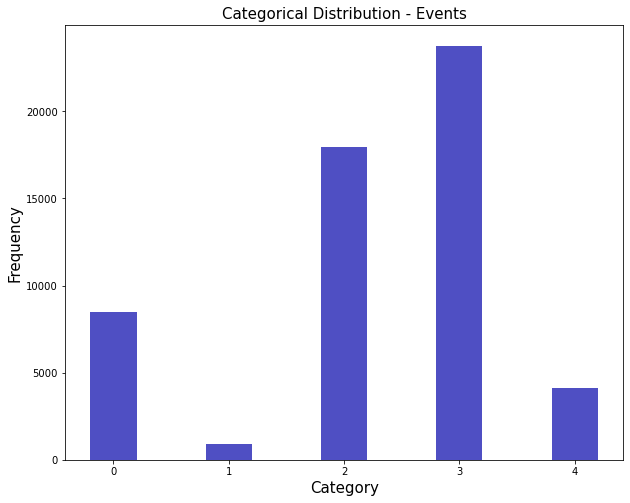

In [128]:
unique_elements, counts_elements = np.unique(event_id_np, return_counts=True)

plt.figure(figsize=[10, 8])
p = plt.bar(unique_elements, counts_elements, color='#0504aa',alpha=0.7, width=.4)
plt.xlabel('Category',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Categorical Distribution - Events',fontsize=15)
plt.show()

Our dataset is imbalanced. The event 'offer viewed' and 'green flag' are the least occuring events compared to the other events.

4. Bi-variate Analysis

Bi-variate Analysis finds out the relationship between two variables. Here, we look for association and disassociation between variables at a pre-defined significance level. We can perform bi-variate analysis for any combination of categorical and continuous variables.

We will be considering the following combination of variables:

1. Age & Income.

2. Offer ID & Registration Month

3. Event ID & Gender

4.1. Categorical & Categorical

To find the relationship between two categorical variables

Event ID & Gender

In [129]:
event_ids = np.unique(event_id_np)

other_list = np.empty(shape=0, dtype=np.int64)
male_list = np.empty(shape=0, dtype=np.int64)
female_list = np.empty(shape=0, dtype=np.int64)

for i in range(len(event_ids)):
    gender_count = data[data['event_id']==i].gender.value_counts(sort=False)
    
    other_list = np.append(other_list, gender_count[0])
    male_list = np.append(male_list, gender_count[1])
    female_list = np.append(female_list, gender_count[2])

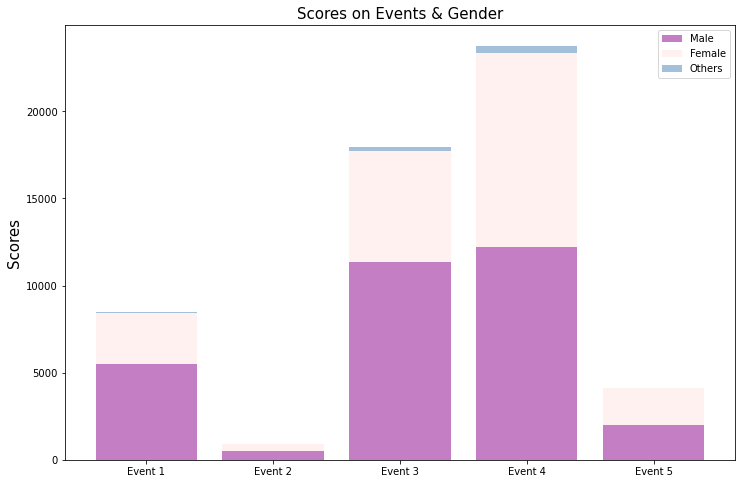

In [130]:
plt.figure(figsize=[12, 8])
p1 = plt.bar(event_ids, male_list, alpha=0.5, color='#8b008b')
p2 = plt.bar(event_ids, female_list, bottom=male_list, alpha=0.5, color='#ffe4e1')
p3 = plt.bar(event_ids, other_list, bottom=male_list+female_list, alpha=0.5, color='#4682b4')
plt.ylabel('Scores', fontsize=15)
plt.title('Scores on Events & Gender', fontsize=15)
plt.legend((p1[0], p2[0], p3[0]), ('Male', 'Female', 'Others'))
plt.xticks(event_ids, ('Event 1', 'Event 2', 'Event 3', 'Event 4', 'Event 5'))
plt.show()

Looks like there is no correlation between the Event ID and Gender

4.2. Continuous & Continuous

To find the relationship between two continuous variables.

Age & Income

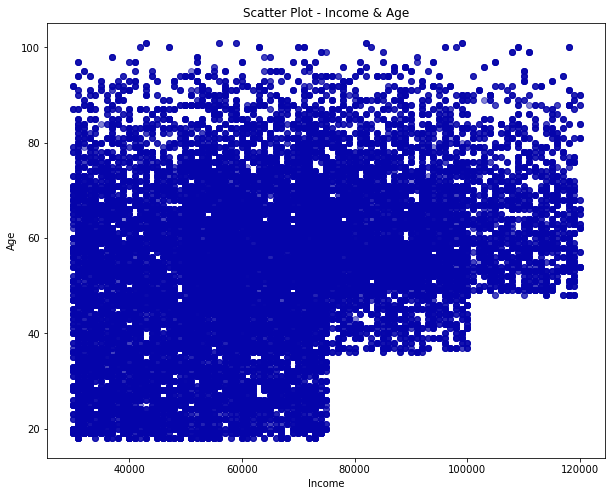

In [131]:
fig = plt.figure(figsize=[10, 8])
plt.scatter(income_np, age_np, color='#0504aa', alpha=0.5)
plt.title('Scatter Plot - Income & Age')
plt.xlabel('Income')
plt.ylabel('Age')
plt.show()

We can observe from the figure that there is a stepwise increase in the income as the age value increases. But we may not be bothered about the same as it’s not a linear correlation.

4.3. Continuous & Categorical

To find the relationship between a continuous and a catagorical variables.

Offer ID & Registration Month

<AxesSubplot:title={'center':'reg_month'}, xlabel='offer_id'>

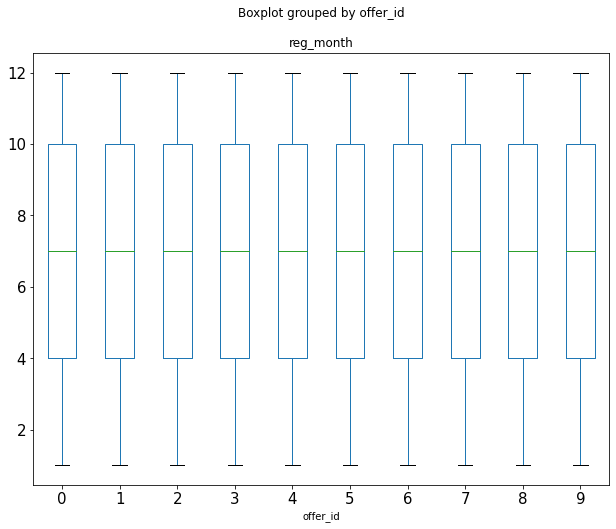

In [132]:
fig, ax = plt.subplots(figsize=[10, 8])
data.boxplot(column='reg_month', by='offer_id', ax=ax, grid=False, fontsize=15)

Correlation among the variables can be inferred from the graph, thus we may try modeling without and with the variable ‘reg_month’. We can also infer that there are no outliers.

5. Outliers Detection

Let’s use the mathematical function ‘Z-score’ to detect the outliers in the dataset. While calculating the ‘Z-score’ we re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. We have set a threshold of 3 and -3 i.e. if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers.

In [133]:
from scipy import stats

In [134]:
z_score_data = np.abs(stats.zscore(data))
threshold = 3
print(np.where(z_score_data > 3))

(array([], dtype=int64), array([], dtype=int64))


There aren't any outliers to treat using the mathematical function z-score and from the above visualizations.

6. Multi-dimensional Scaling


Multidimensional scaling is a means of visualizing the level of similarity of individual objects of a dataset. It is used to translate information about the pairwise distances among a set of n objects or individuals into a configuration of n points mapped into an abstract Cartesian space.

We may use this method to scale our dataset dimension into just two components such that the relative distance between the data points are maintained. And then we may scatter plot each class in the dataset into the x-y plane. This may give us a narrow idea about the underlying structure of each class in the dataset.

In [135]:
from sklearn.manifold import MDS

In [136]:
#seperate the inputs and output from the dataset.
target = data['event_id']
predictors = data.drop(['id', 'event_id'], axis=1)

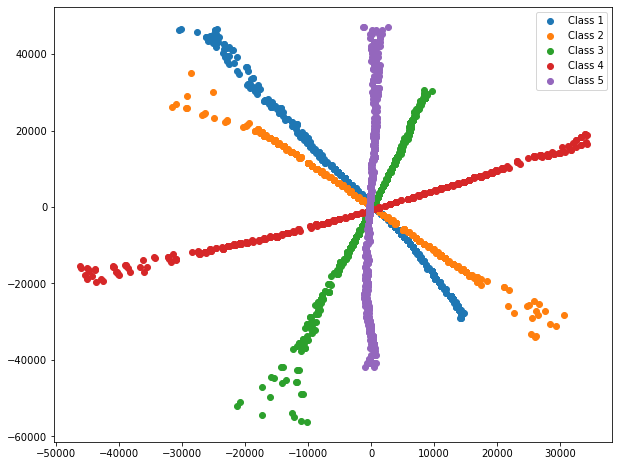

In [138]:
def scatter_plot(event, event_name):
    """To plot records of the passed class or event.
    
    The function perform MDS on the data and scatter plot the same into the 2d space.
    
    Args : 
        
        event (dataframe) - It's the records of the corresponding event.
        event_name (str) - Specifies event name. 
           
    Returns:
        
        None.
        
    """
    sample = event.head(600)
    clf = MDS(n_components=2, n_init=2, max_iter=100, dissimilarity='euclidean')
    X_mds = clf.fit_transform(sample.values)
    cords = X_mds
    scatter = plt.scatter(cords[:, 0], cords[:, 1], label=event_name)  

plt.figure(figsize=[10, 8])

#selecting records corresponding to each event or class and passing it to the function 'scatter_plot'
class_name = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
for i in range(5):
    event = predictors[target==i]
    scatter_plot(event, class_name[i])
    
plt.legend()

From the figure, we can observe that each class in the dataset is separable and is suitable for classification problems. And, from the structure of the data points we can infer that we may need to use a nonlinear function or model to solve the same.